In [1]:
import torch
import torch.nn as nn
import torch.nn.init
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mnist_train = dsets.MNIST(root='./data/', train=True, transform=transforms.ToTensor(), download=True)
mnist_test = dsets.MNIST(root='./data/', train=False, transform=transforms.ToTensor(), download=True)

In [4]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=1, shuffle=False)

In [5]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

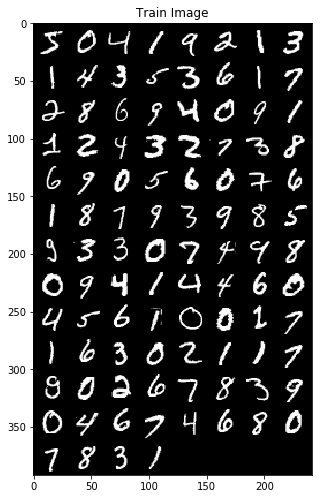

In [6]:
images, labels = iter(train_loader).next()
imshow(torchvision.utils.make_grid(images, normalize=True), "Train Image")

In [7]:
images.shape

torch.Size([100, 1, 28, 28])

# Define Model

In [8]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 5), # 16 * 24 * 24
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 5), # 32 * 20 * 20
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 32 * 10 * 10
            nn.BatchNorm2d(32), 
            nn.Conv2d(32, 64, 3), # 64 * 8 * 8
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64 * 4 * 4
            nn.Conv2d(64, 32, 3) # 32 * 2 * 2
        )
        
        self.fc_layer = nn.Sequential(
            nn.Linear(32 * 2 * 2, 100),
            nn.ReLU(),
            nn.Linear(100, 100)
        )
        
    def forward(self, x):
        out = self.encoder(x)
        out = out.view(-1, 32 * 2 * 2)
        z = self.fc_layer(out)
        
        return z

In [9]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.fc_layer = nn.Sequential(
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 32 * 2 * 2) # 32 * 2 * 2 => 2 => input
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 4, stride = 1, padding = 1), # 1 * (2 - 1) + 4 - 2 => 3
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 5, stride = 2, padding = 1), # 2 * (3 - 1) + 5 - 2 => 7
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, 4, stride = 2, padding = 1), # 2 * (7 - 1) + 4 - 2 => 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, 4, stride = 2, padding = 1), # 2 * (14 - 1) + 4 - 2 => 28
            nn.ReLU()
        )
        
    def forward(self, z):
        out = self.fc_layer(z)
        out = out.view(-1, 32, 2, 2)
        out = self.decoder(out)
        return out

In [10]:
E = Encoder().cuda()
D = Decoder().cuda()

In [11]:
E(torch.randn(100, 1, 28, 28).cuda()).shape

torch.Size([100, 100])

In [12]:
D(torch.randn(100, 100).cuda()).shape

torch.Size([100, 1, 28, 28])

# Model Training

In [13]:
loss = nn.MSELoss()
optimizer = optim.Adam(list(E.parameters()) + list(D.parameters()), lr = 0.001)

In [14]:
num_epochs = 5

In [15]:
for epoch in range(num_epochs):
    total_batch = len(mnist_train) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        X = batch_images.cuda()
        pre = D(E(X))
        # z = E(X)
        # pre = D(z)
        cost = loss(pre, X)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i + 1) % 100 == 0:
            print('Epoch [%d/%d], Iter [%d/%d], Loss: %.4f' % (epoch + 1, num_epochs, i + 1, total_batch, cost.item()))
            
print("Learning Finished!!")

Epoch [1/5], Iter [100/600], Loss: 0.0446
Epoch [1/5], Iter [200/600], Loss: 0.0341
Epoch [1/5], Iter [300/600], Loss: 0.0232
Epoch [1/5], Iter [400/600], Loss: 0.0194
Epoch [1/5], Iter [500/600], Loss: 0.0173
Epoch [1/5], Iter [600/600], Loss: 0.0258
Epoch [2/5], Iter [100/600], Loss: 0.0141
Epoch [2/5], Iter [200/600], Loss: 0.0148
Epoch [2/5], Iter [300/600], Loss: 0.0133
Epoch [2/5], Iter [400/600], Loss: 0.0125
Epoch [2/5], Iter [500/600], Loss: 0.0120
Epoch [2/5], Iter [600/600], Loss: 0.0173
Epoch [3/5], Iter [100/600], Loss: 0.0112
Epoch [3/5], Iter [200/600], Loss: 0.0116
Epoch [3/5], Iter [300/600], Loss: 0.0106
Epoch [3/5], Iter [400/600], Loss: 0.0100
Epoch [3/5], Iter [500/600], Loss: 0.0100
Epoch [3/5], Iter [600/600], Loss: 0.0146
Epoch [4/5], Iter [100/600], Loss: 0.0093
Epoch [4/5], Iter [200/600], Loss: 0.0096
Epoch [4/5], Iter [300/600], Loss: 0.0090
Epoch [4/5], Iter [400/600], Loss: 0.0090
Epoch [4/5], Iter [500/600], Loss: 0.0090
Epoch [4/5], Iter [600/600], Loss:

# Test Model

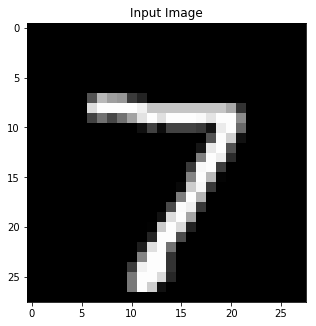

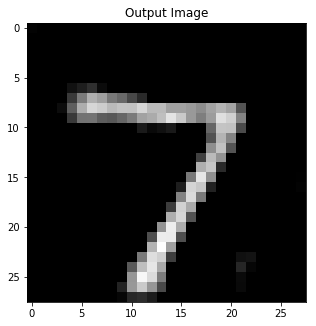

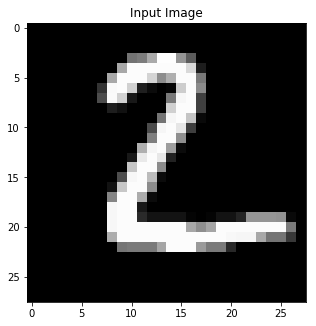

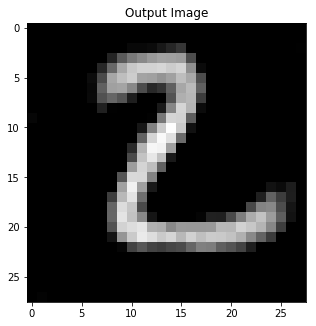

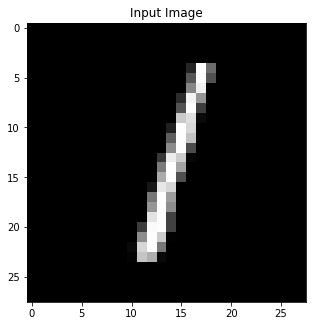

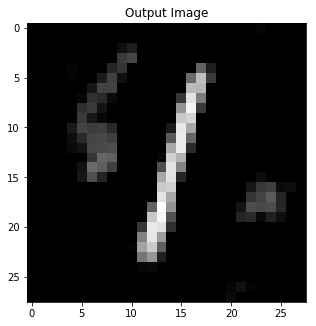

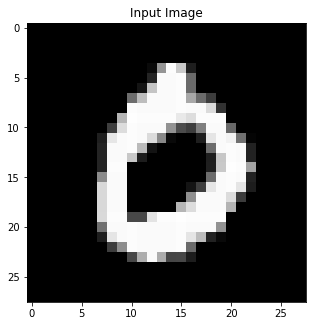

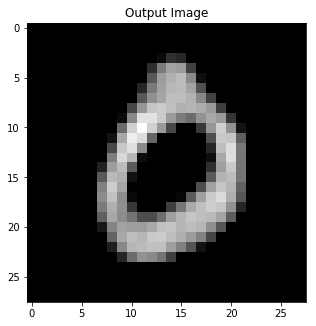

In [16]:
E.eval()
D.eval()

for n, (images, labels) in enumerate(test_loader):
    imshow(torchvision.utils.make_grid(images, normalize=True), "Input Image")
    
    images = images.cuda()
    outputs = D(E(images))
    
    imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    
    if n > 2 : break

# Make Random Image

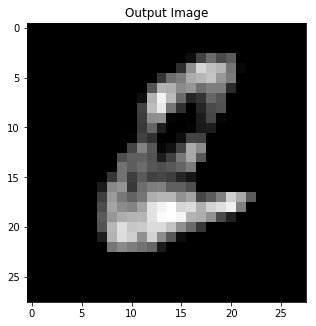

In [17]:
z = torch.rand(E(images).size()).cuda()
outputs = D(z)
imshow(torchvision.utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")